# Le problème : la prévision de consommation électrique

Pour garantir l'équilibre offre-demande à chaque instant et gérer l'acheminement de l'électricité, RTE construit ses propres prévisions de la consommation nationale, régionale, et locale, à différentes échéances de temps (de l'infrajournalier au pluri-annuel).

Ici on se focalise sur un problème particulier : **la prévision de la consommation électrique nationale horaire à horizon J+1**. 

## Les données : Eco2mix

La courbe de charge France est disponible sur eco2mix :
http://www.rte-france.com/fr/eco2mix/eco2mix
ou sur application mobile.

Vous pouvez naviguer sur le site pour vous familiariser avec les données sur lesquelles vous allez travailler.

## Objectif :

Au cours de cette étude de cas, nous allons aborder les différentes étapes nécessaires à la construction d'un modèle de prévision de consommation :

1) Formalisation du problème Y = f(X): que souhaite-t-on prédire (quel est mon Y) ? Avec quelles variables explicatives (quel est mon X) ?

2) Collecte des données : où se trouvent les données ? Quel est le format ? Comment les récupérer ?

3) Import des données et analyses descriptives : visualiser des séries temporelles, statistiques descriptives

4) Transformation des données (feature engineering) pour entrainer et tester un premier modèle

5) Création de prévision à dire d'expert pour servir de référence

6) Découpage des données : apprentissage - test

7) Evaluer un modèle

8) Tester des algorithmes de référence : régression linéaire, forêts aléatoires

9) Itérer à partir des modèles testés pour améliorer les prévisions

Nous verrons qu'une difficulté majeure réside dans la construction des "bonnes" variables explicatives ("garbage in, garbage out").

**Le notebook est parsemé de questions (<font color='green'>en vert</font>).

## Méthodes de prévision considérées

Les modèles actuels reposent sur des méthodes de régression linéaires et non-linéaires. Nous étudierons ici les limites de la régression linéaire.

Pour améliorer les prévisions, nous aurons recours aux méthodes dites de Machine Learning. Ces méthodes ne dépendent pas d'une formalisation a priori du lien entre les variables explicatives X et la variable à expliquer Y. 
Elles sont souvent moins interprétables mais peuvent être plus efficaces en prévision. Elles peuvent nécessiter plus de temps de calcul et plus de données pour cela.

Construire un bon modèle d'apprentissage nécessite en général de la connaissance experte dans le domaine d'intérêt pour créer des modèles pertinents et efficaces. 

## To be continued : deep learning

La deuxième étude de cas permettra d'investiguer les modèles "Deep" avec réseaux de neurones, en montrant le moindre besoin en feature engineering et leur plus grande capacité à absorber l'information grâce aux représentations hiérarchiques qu'ils créent.

# Environnement de travail 

Ceci est un notebook jupyter. Il permet d'exécuter du code python, d'afficher des résultats et d'écrire du texte pour décrire l'ensemble de l'étude.

<font color='red'>
    
**NB : L'aide de python est accessible en tapant help(nom_de_la_commande)**

</font>

## Chargement des packages

In [1]:
# Exécutez la cellule ci-dessous (par exemple avec shift-entrée)
# Si vous exécuter ce notebook depuis votre PC, il faudra peut-etre installer certaines librairies avec 
# 'pip install ma_librairie'
import os  # accès aux commandes système
import datetime  # structure de données pour gérer des objets calendaires
from datetime import timezone
import pytz
import pandas as pd  # gérer des tables de données en python
import numpy as np  # librairie d'opérations mathématiques
from math import sqrt
import zipfile  # compresser ou décompresser fichier
import requests, io #get data from url

import sklearn  # librairie de machine learning
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
import matplotlib.pyplot as plt  # tracer des visualisations
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

%autosave 0

Autosave disabled


## Données disponibles

Choix du répertoire de travail "data_folder" dans lequel tous les fichiers csv seront entreposés. Ici le répertoire s'appelle *data*.

Ensuite on affiche les fichiers du répertoire pour vérification

In [2]:
isDataFromGithub=True #True especially if using colab as it only download the notebook and not the entire github repository. Otherwise with Binder or in local, set it False

if(isDataFromGithub):
    data_folder='https://raw.githubusercontent.com/rte-france/Formation_FIFA/master/data'#data depuis github
else:
    data_folder = os.path.join(os.getcwd(), "data") #data en local


In [3]:
if(os.path.isdir(data_folder)):
    print("Mon repertoire est : {}".format(data_folder))
    print("Fichiers contenus dans ce répertoire :")
    for file in os.listdir(data_folder):
        print(" - " + file)

# Récupération des données dans Python

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python : 
- y_conso_tp1.csv
- x_input_tp1.zip

NB : Les données brutes ont été pré-traitées à l'aide du notebook *preparation_donnees.ipynb* pour obtenir ces deux fichiers.

## import des données de consommation (notre Y)

In [4]:
y_conso_csv = os.path.join(data_folder, "y_conso_tp1.csv")
y_conso = pd.read_csv(y_conso_csv)

display(y_conso.head(2)) # affichage des premières lignes
display(y_conso.tail(2)) # affichage des dernières lignes
display(y_conso.info()) # affichage du type de données et de la taille de chaque colonne

print("---")
print("Les dates sont des objets de type :")
print(type(y_conso["ds"].loc[0]))

ds      y
0  2014-01-08 00:00:00+00:00  62008
1  2014-01-08 01:00:00+00:00  57298

ds      y
43366  2018-12-19 22:00:00+00:00  65288
43367  2018-12-19 23:00:00+00:00  67766

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43368 entries, 0 to 43367
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      43368 non-null  object
 1   y       43368 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 677.8+ KB


None

---
Les dates sont des objets de type :
<class 'str'>


La colonne "ds" contient la date, mais celle-ci est reconnue en tant que chaîne de caractères (https://pbpython.com/pandas_dtypes.html) et non en tant qu'objet date. 

On va la convertir en objets de type "datetime" plus appropriés pour extraire des informations comme le jour de la semaine ou l'heure.

In [5]:
y_conso['ds'] = pd.to_datetime(y_conso['ds'], utc=True)

print(y_conso.dtypes)
display(y_conso.head(2))

print("---")
print("Les dates sont des objets de type :")
print(type(y_conso["ds"].loc[0]))

ds    datetime64[ns, UTC]
y                   int64
dtype: object


ds      y
0 2014-01-08 00:00:00+00:00  62008
1 2014-01-08 01:00:00+00:00  57298

---
Les dates sont des objets de type :
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Visuellemement cela ne change rien, pour l'instant, mais plus tard ça nous facilitera la vie pour effectuer des sélections.

On peut afficher la dimension du DataFrame (toujours s'assurer que cela correspond aux valeurs attendues) : 

In [6]:
print(y_conso.shape)

(43368, 2)


## Import des variables d'entrée du modèle prédictif 

**Attention : Les données présentes dans Xinput sont encryptées dans un fichier zip.**  
Pour les lire vous avez besoin d'un mot de passe qui ne peut vous être donné que dans le cadre d'un travail au sein de RTE.

Sinon, la lecture se déroule comme pour le fichier Yconso.csv : transformation en datetime de la colonne *ds* et vérification des dimensions.

In [8]:
password = ""

In [9]:
x_input_zip = os.path.join(data_folder, "x_input_tp1.zip")
if(isDataFromGithub):
    ####data sur github
    r = requests.get(x_input_zip)
    zipfile_xinput = zipfile.ZipFile(io.BytesIO(r.content))
else:
    ######data en local
    zipfile_xinput = zipfile.ZipFile(x_input_zip)

# Pour travailler avec les fichiers zip, on utilise la bibliothèque **zipfile**.
zipfile_xinput.setpassword(bytes(password, 'utf-8'))
x_input = pd.read_csv(zipfile_xinput.open('X2input.csv'), sep=",", engine='c', header=0)

x_input['ds'] = pd.to_datetime(x_input['ds'], utc=True)

Ce fichier pourrait éventuellement être enrichi à l'aide d'autres sources de données (cf. le notebook de préparation des données).

In [10]:
print("Dimensions de X")
print(x_input.shape)

Dimensions de X
(43368, 81)


In [11]:
print("Colonnes de X")
print(x_input.columns)

Colonnes de X
Index(['ds', 'holiday', '002_0', '002_24', '005_0', '005_24', '015_0',
       '015_24', '027_0', '027_24', '070_0', '070_24', '110_0', '110_24',
       '120_0', '120_24', '130_0', '130_24', '145_0', '145_24', '149_0',
       '149_24', '156_0', '156_24', '168_0', '168_24', '180_0', '180_24',
       '190_0', '190_24', '222_0', '222_24', '240_0', '240_24', '255_0',
       '255_24', '260_0', '260_24', '280_0', '280_24', '299_0', '299_24',
       '434_0', '434_24', '460_0', '460_24', '481_0', '481_24', '497_0',
       '497_24', '510_0', '510_24', '579_0', '579_24', '588_0', '588_24',
       '621_0', '621_24', '630_0', '630_24', '643_0', '643_24', '645_0',
       '645_24', '650_0', '650_24', '675_0', '675_24', '690_0', '690_24',
       '747_0', '747_24', 'Th_real_24h_avant', 'Th_prev', 'month', 'hour',
       'weekday', 'lag1H', 'lag1D', 'lag1W', 'posan'],
      dtype='object')


In [12]:
print("Aperçu de X")
display(x_input.head(35))

Aperçu de X


ds holiday  002_0  002_24  005_0  005_24  015_0  \
0  2014-01-08 00:00:00+00:00     NaN  10.30    9.69  10.00    9.80   9.69   
1  2014-01-08 01:00:00+00:00     NaN  10.10    9.40   9.69    9.80   9.40   
2  2014-01-08 02:00:00+00:00     NaN  10.00    9.19   9.90    9.60   9.19   
3  2014-01-08 03:00:00+00:00     NaN   9.90    9.00   9.50    9.19   9.19   
4  2014-01-08 04:00:00+00:00     NaN   9.90    8.80   9.00    8.90   8.90   
5  2014-01-08 05:00:00+00:00     NaN   9.69    9.40   9.40    9.10   9.30   
6  2014-01-08 06:00:00+00:00     NaN   9.60    9.19   9.60    8.90   9.19   
7  2014-01-08 07:00:00+00:00     NaN   9.60    9.50   9.50    8.60   9.19   
8  2014-01-08 08:00:00+00:00     NaN   9.90    9.40   9.19    8.60   9.30   
9  2014-01-08 09:00:00+00:00     NaN  10.00    9.40  10.00    9.10   9.69   
10 2014-01-08 10:00:00+00:00     NaN  10.40    9.00  10.00    9.69  10.30   
11 2014-01-08 11:00:00+00:00     NaN  10.50    9.40  11.80   10.60  10.70   
12 2014-01-08 12:00:00+00:00     NaN  10.60    9.80  12.60   11.30  11.80   
13 2014-01-08 13:00:00+00:00     NaN  10.90   10.00  12.60   11.40  12.80   
14 2014-01-08 14:00:00+00:00     NaN  11.20    9.90  12.60   11.30  12.70   
15 2014-01-08 15:00:00+00:00     NaN  11.30    9.69  12.80   11.10  12.20   
16 2014-01-08 16:00:00+00:00     NaN  11.10    9.69  11.90   10.90  11.40   
17 2014-01-08 17:00:00+00:00     NaN  10.50    9.50  11.50   10.70  11.10   
18 2014-01-08 18:00:00+00:00     NaN  10.80    9.60  10.80   10.60  10.80   
19 2014-01-08 19:00:00+00:00     NaN  11.00    9.80   9.90   10.60  10.40   
20 2014-01-08 20:00:00+00:00     NaN  10.80   10.00  10.10   10.80  10.10   
21 2014-01-08 21:00:00+00:00     NaN  10.40   10.19   9.69   10.70   9.60   
22 2014-01-08 22:00:00+00:00     NaN  10.10   10.70  10.30   10.80   9.50   
23 2014-01-08 23:00:00+00:00     NaN   9.50   11.00  10.40   11.10   9.80   
24 2014-01-09 00:00:00+00:00     NaN   8.80   11.40  10.90   11.30   9.80   
25 2014-01-09 01:00:00+00:00     NaN   8.30   11.60   8.50   11.40  10.50   
26 2014-01-09 02:00:00+00:00     NaN   9.19   11.70   8.69   11.50   9.80   
27 2014-01-09 03:00:00+00:00     NaN   9.50   11.90   8.80   11.60   8.80   
28 2014-01-09 04:00:00+00:00     NaN   9.60   12.00   8.10   11.70   8.80   
29 2014-01-09 05:00:00+00:00     NaN   9.80   10.60   8.50   10.19   8.90   
30 2014-01-09 06:00:00+00:00     NaN   9.50   10.60   7.40   10.40   9.10   
31 2014-01-09 07:00:00+00:00     NaN   9.40   11.10   7.00   10.70   8.80   
32 2014-01-09 08:00:00+00:00     NaN   9.10   11.30   6.80   10.90   8.19   
33 2014-01-09 09:00:00+00:00     NaN   8.80   11.30   7.10   11.10   8.40   
34 2014-01-09 10:00:00+00:00     NaN   8.90   10.10   8.40   11.30   9.40   

    015_24  027_0  027_24  ...  747_24  Th_real_24h_avant    Th_prev  month  \
0     9.30  10.19   10.50  ...   11.20           9.846930   9.911160      1   
1     9.30  10.30   10.30  ...   11.10           9.848500   9.790830      1   
2     9.40  10.30   10.00  ...   11.00           9.681580   9.634990      1   
3     9.19  10.19    9.80  ...   10.90           9.487130   9.445360      1   
4     9.00  10.19    9.60  ...   10.80           9.490410   9.241585      1   
5     9.40  10.10    9.50  ...    9.19           9.346880   9.045105      1   
6     9.10  10.30    9.50  ...    9.00           9.284855   8.915265      1   
7     9.50  10.50    9.60  ...    9.50           9.377060   8.964100      1   
8     9.50  10.70    9.50  ...    9.90           9.543030   9.106500      1   
9     9.80  10.80    9.60  ...   10.70          10.109460   9.630050      1   
10    9.69  11.60    9.90  ...   10.80          11.010330  10.447800      1   
11   10.60  11.60   10.40  ...   12.00          12.087900  11.583100      1   
12   11.20  12.50   11.00  ...   12.90          12.750200  12.571250      1   
13   11.30  12.80   11.30  ...   13.30          13.010425  13.199100      1   
14   11.20  12.90   11.40  ...   13.40          13.034650  13.415650

Dans cette étude de cas, par soucis de simplicité, nous allons travailler uniquement avec des
**températures France**. Utiliser les températures des différentes stations météo serait une piste
intéressante pour améliorer le modèle.

In [13]:
x_input = x_input[['ds', 'month', 'hour', 'posan', 'weekday', 'holiday', 'Th_real_24h_avant', 'Th_prev', 'lag1D', 'lag1W']]

<font color='green'>
    
* Quelles sont les variables disponibles (dans x_input et y_conso)?
    
* Quelles sont les dimensions (nombre d’observations et de variables) de x_input et y_conso après lecture des fichiers csv? Est-ce cohérent?

* Les données présentes dans x_input vous semblent-elles pertinentes pour prédire la consommation nationale présente dans y_conso ?

* Que pensez-vous de cette notion de "Température France"?
</font>

# Visualisation des données 

La DataScience et le Machine Learning supposent de bien appréhender les données sur lesquelles nos modèles vont être entrainés. Pour cela, il est utile de faire des statistiques descriptives et des visualisations de nos différentes variables.

Traitant d'un problème de prévision, on visualisera en particulier des séries temporelles.

Dans les slides d'introduction, vous allez voir des :
- échantillons de données
- profils de courbe de consommation journaliers et saisonniers
- visualisations de corrélation entre conso J et conso retardée


# Outils de construction de modèle
<img src="pictures/etabli.jpg"  width=500 >

## Construction des jeux d'entrainement et de test

Pour éviter de construire un modèle qui apprend "par coeur" sur ses données, et qui disposerait alors d'une capacité de généralisation faible, il est d'usage courant de disposer de plusieurs jeux de données (de caractéristiques similaires). Le minimum est de construire 

* un jeu d'entraînement, sur lequel on cale les paramètres du modèle, 

* un jeu de test, jamais vu durant l'entraînement, sur lequel on va évaluer le modèle. 

Rapidement dit : un bon modèle est un modèle dont la capacité prédictive ne se dégrade pas trop sur le jeu test.

Pour cela, on crée la fonction *prepareDataSetEntrainementTest* qui va permettre de couper Y et Xinput en deux parties.

In [14]:
def prepareDataSetEntrainementTest(x, y, date_debut, date_rupture, nb_jours_lag_regresseur=0):
    
    dateStart = x.iloc[0]['ds']
    
    # si un a un regresseur avec du lag, il faut prendre en compte ce lag 
    # et commencer l'entrainement a la date de debut des donnees+ce lag
    DateStartWithLag = dateStart + pd.Timedelta(str(nb_jours_lag_regresseur) + ' days')
    
    x_test = x[(x.ds >= date_rupture)]
    x_train = x[(x.ds < date_rupture) & (x.ds > DateStartWithLag) & (x.ds > date_debut)]
    y_train = y[(y.ds < date_rupture) & (y.ds > DateStartWithLag) & (y.ds > date_debut)]
    y_test = y[(x.ds >= date_rupture)]
    
    return x_train, x_test, y_train, y_test

## Fonctions utilitaires

Créons la fonction modelError qui va calculer pour un échantillon (y, y_hat) différents scores :
- erreur relative moyenne (MAPE en %)
- erreur relative max (en %)
- RMSE (en MW)

Cette fonction est ensuite utilisée par les fonctions *evaluation* et *evaluation_par* qui nous permettront d'évaluer nos modèles.

<img src="pictures/evaluation.jpg"  width=250 >

In [15]:
def modelError(y_true, y_hat):

    Y = y_true.reset_index(drop=True).copy()
    
    relative_errors = np.abs((Y['y'] - y_hat) / Y['y']) 
    mean_error = np.mean(relative_errors)
    max_error = np.max(relative_errors)
    rmse = np.sqrt(mean_squared_error(Y['y'], y_hat))
   
    return relative_errors, mean_error, max_error, rmse

In [16]:
def evaluation(y_train, y_test, y_train_hat, y_test_hat):
    # Ytrain et Ytest ont deux colonnes : ds et y
    # YtrainHat et YTestHat sont des vecteurs
    
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(y_test, y_test_hat)
    print("l'erreur relative moyenne de test est de :" + str(round(ErreurMoyenneTest * 100, 1)) + "%")
    print("l'erreur relative max de test est de :" + str(round(ErreurMaxTest * 100, 1)) + "%")
    print('le rmse de test est de :' + str(round(RMSETest, 0)))
    print()
    
    ErreursTest, ErreurMoyenneTest, ErreurMaxTest, RMSETest = modelError(y_train, y_train_hat)
    print("l'erreur relative moyenne de train est de :" + str(round(ErreurMoyenneTest * 100, 1)) + "%")
    print("l'erreur relative max de train est de :" + str(round(ErreurMaxTest * 100, 1)) + "%")
    print('le rmse de test est de :' + str(round(RMSETest, 0))) 

In [17]:
def evaluation_par(X, Y, Yhat, avec_JF=True):
    Ytmp = Y.copy()
    Ytmp['weekday'] = Ytmp.ds.dt.weekday
    Ytmp['hour'] = Ytmp.ds.dt.hour
    if(avec_JF):
        Ytmp['jours_feries'] = X['jours_feries'].values
    Ytmp['APE'] = np.abs(Ytmp['y'] - Yhat) / Ytmp['y']
    dataWD = Ytmp[['weekday', 'APE']]
    groupedWD = dataWD.groupby(['weekday'], as_index=True)
    statsWD = groupedWD.aggregate([np.mean])
    dataHour = Ytmp[['hour', 'APE']]
    groupedHour = dataHour.groupby(['hour'], as_index=True)
    statsHour = groupedHour.aggregate([np.mean])
    
    if(avec_JF):
        dataJF = Ytmp[['jours_feries', 'APE']].copy()
        groupedJF = dataJF.groupby(['jours_feries'], as_index=True)
        statsJF = groupedJF.aggregate([np.mean])
    else:
        statsJF = None
    
    return statsWD, statsHour, statsJF

# Préparation des variables explicatives : préparation de Xinput

L'objectif de cette partie est d'enrichir Xinput à partir des données initiales. Il s'agit notamment d'exploiter les différentes informations calendaires disponibles.

On encode les données calendaires en **one-hot encoding** pour le modèle. Autrement dit, on construit pour chaque modalité, une variable binaire associée.
Cet encodage est nécessaire pour que le modèle mathématique puisse appréhender la notion de date.

In [18]:
encoded_weekday = pd.get_dummies(x_input['weekday'], prefix="weekday")
encoded_month = pd.get_dummies(x_input['month'], prefix="month")
encoded_hour = pd.get_dummies(x_input['hour'], prefix="hour")

In [19]:
encoded_weekday.head(3)

weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6
0          0          0          1          0          0          0          0
1          0          0          1          0          0          0          0
2          0          0          1          0          0          0          0

In [20]:
encoded_month.head(3)

month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0        1        0        0        0        0        0        0        0   
1        1        0        0        0        0        0        0        0   
2        1        0        0        0        0        0        0        0   

   month_9  month_10  month_11  month_12  
0        0         0         0         0  
1        0         0         0         0  
2        0         0         0         0

In [21]:
encoded_hour.head(3)

hour_0  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
0       1       0       0       0       0       0       0       0       0   
1       0       1       0       0       0       0       0       0       0   
2       0       0       1       0       0       0       0       0       0   

   hour_9  ...  hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  \
0       0  ...        0        0        0        0        0        0        0   
1       0  ...        0        0        0        0        0        0        0   
2       0  ...        0        0        0        0        0        0        0   

   hour_21  hour_22  hour_23  
0        0        0        0  
1        0        0        0  
2        0        0        0  

[3 rows x 24 columns]

In [22]:
x_input = pd.concat([x_input, encoded_month, encoded_weekday, encoded_hour], axis=1)
x_input = x_input.drop(columns=['month', 'weekday', 'hour'])

In [23]:
print(x_input.shape)
print(x_input.columns)

(43368, 50)
Index(['ds', 'posan', 'holiday', 'Th_real_24h_avant', 'Th_prev', 'lag1D',
       'lag1W', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


On crée une variable binaire associée à chaque jour férié.

In [24]:
#Récupération des jours fériés dans Xinput
encoded_holidays = pd.get_dummies(x_input[['holiday']], prefix="JF")
encoded_holidays['jours_feries'] = encoded_holidays.sum(axis=1)
x_input = pd.concat([x_input, encoded_holidays], axis=1)
x_input = x_input.drop(['holiday'], axis=1)

On ajoute des températures seuillées, à 15°C pour l'effet chauffage, et à 18°C pour l'effet climatisation.

In [25]:
threshold_temperature_heat = 15
threshold_temperature_cool = 18

x_input['temp_prev_with_threshold_heat'] = np.maximum(0, threshold_temperature_heat - x_input['Th_prev'].values)
x_input['temp_prev_with_threshold_cool'] = np.maximum(0, x_input['Th_prev'].values - threshold_temperature_cool)

In [26]:
# Affichage de toutes les variables de base
list(x_input)  # list plutôt que print pour avoir la liste complète

['ds',
 'posan',
 'Th_real_24h_avant',
 'Th_prev',
 'lag1D',
 'lag1W',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'JF_11Novembre',
 'JF_1erMai',
 'JF_8Mai',
 'JF_Ascension',
 'JF_Assomption',
 'JF_FeteNationale',
 'JF_Noel',
 'JF_NouvelAn',
 'JF_Paques',
 'JF_Pentecote',
 'JF_Toussaint',
 'jours_feries',
 'temp_prev_with_threshold_heat',
 'temp_prev_with_threshold_cool']

Enfin, nous construisons les listes pour appeler plus rapidement les colonnes d'un même type.

In [27]:
cols_to_keep_weather = [s for s in x_input.columns if 'Th_prev' in s]
cols_to_keep_month = [v for v in x_input.columns if 'month' in v]
cols_to_keep_weekday = [v for v in x_input.columns if 'weekday' in v]
cols_to_keep_hour = [v for v in x_input.columns if 'hour' in v]
cols_to_keep_holidays = [v for v in x_input.columns if 'JF_' in v]

In [28]:
# on souhaite un jeu de test qui commence à partir du 1er mai 2017
date_debut = pytz.utc.localize( datetime.datetime(year=2014, month=1, day=15))  # pour éviter les NaN dans le jeu de données
date_rupture = pytz.utc.localize(datetime.datetime(year=2017, month=12, day=1))  # début du challenge prevision de conso
nb_jours_lag_regresseur = 0

In [29]:
y_conso.tail()

ds      y
43363 2018-12-19 19:00:00+00:00  75670
43364 2018-12-19 20:00:00+00:00  73068
43365 2018-12-19 21:00:00+00:00  68589
43366 2018-12-19 22:00:00+00:00  65288
43367 2018-12-19 23:00:00+00:00  67766

In [30]:
x_train, x_test, y_train, y_test = prepareDataSetEntrainementTest(
    x_input, 
    y_conso, 
    date_debut, 
    date_rupture, 
    nb_jours_lag_regresseur
)

In [31]:
print('La taille de l échantillon XinputTrain est : ' + str(x_train.shape))
print('La taille de l échantillon XinputTest est : ' + str(x_test.shape))
print('La taille de l échantillon YconsoTrain est : ' + str(y_train.shape))
print('La taille de l échantillon YconsoTest est : ' + str(y_test.shape))
print("La proportion de data d'entrainement est de : " + str(round(y_train.shape[0] / (y_train.shape[0] + y_test.shape[0]), 2)) + "%")

La taille de l échantillon XinputTrain est : (33983, 63)
La taille de l échantillon XinputTest est : (9216, 63)
La taille de l échantillon YconsoTrain est : (33983, 2)
La taille de l échantillon YconsoTest est : (9216, 2)
La proportion de data d'entrainement est de : 0.79%


# Construction d'un modèle prédictif naïf

<img src="pictures/hommeNaif.png" width=500 >

## Une idée de modèle naïf : on plaque bêtement la valeur de consommation nationale de la veille
Ce modèle n'a même pas besoin de regarder le jeu d'entrainement !

In [32]:
pred_train_naif_1 = x_train["lag1D"]
pred_test_naif_1 = x_test["lag1D"]

evaluation(y_train, y_test,  pred_train_naif_1.values, pred_test_naif_1.values)

l'erreur relative moyenne de test est de :5.7%
l'erreur relative max de test est de :37.8%
le rmse de test est de :4528.0

l'erreur relative moyenne de train est de :5.8%
l'erreur relative max de train est de :41.0%
le rmse de test est de :4590.0


Bon c'est pas fou...

# Modèle Type Système Expert (boîte blanche)

Chez RTE, on considère qu'une augmentation moyenne de 1°C conduit à une augmentation de 2400MW de la consommation nationale pour des températures inférieures à 15°C. On propose donc comme consommation prévue la consommation de la veille, corrigée par 2400 fois l'écart à la température de la veille, si l'on n'excède pas les 15°C.


<img src="pictures/ExpertJamy.jpg" width=500 >

## Definition des régles expertes

In [33]:
# Petit rappel
print(threshold_temperature_heat)

15


In [34]:
# C'est ici que l'on fait intervenir notre expertise !
delta_MW_par_degre = 2400

In [35]:
# prévision train
temp_prev_with_threshold = np.minimum([threshold_temperature_heat], x_train['Th_prev'].values)
temp_actual_with_threshold = np.minimum([threshold_temperature_heat], x_train['Th_real_24h_avant'].values)

delta_temp = temp_prev_with_threshold - temp_actual_with_threshold
delta_MW_because_temp = delta_temp * delta_MW_par_degre

pred_train_naif_2 = x_train["lag1D"] - delta_MW_because_temp

# prévision test
temp_prev_with_threshold = np.minimum([threshold_temperature_heat], x_test['Th_prev'].values)
temp_actual_with_threshold = np.minimum([threshold_temperature_heat], x_test['Th_real_24h_avant'].values)

delta_temp = temp_prev_with_threshold - temp_actual_with_threshold
delta_MW_because_temp = delta_temp * delta_MW_par_degre
pred_test_naif_2 = x_test["lag1D"] - delta_MW_because_temp

# scores
evaluation(y_train, y_test,  pred_train_naif_2.values, pred_test_naif_2.values)

l'erreur relative moyenne de test est de :6.7%
l'erreur relative max de test est de :40.1%
le rmse de test est de :5015.0

l'erreur relative moyenne de train est de :6.9%
l'erreur relative max de train est de :44.1%
le rmse de test est de :5045.0


Bon... Bien essayé avec ces modèles bricolés, mais maintenant on va être plus sérieux !

# Apprentissage Automatique


## Régression linéaire simple (boîte grise)

Le modèle naïf avec expertise métier a été inspiré de la forme de la courbe d'évolution de la consommation en fonction de la température en France. 

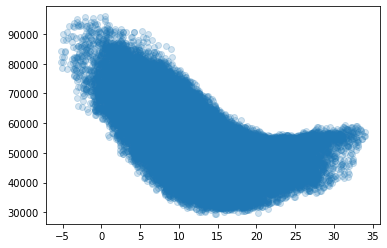

In [36]:
plt.scatter(x_input['Th_prev'], y_conso['y'], alpha=0.2)
plt.show()

La consommation pourrait être modélisée par une fonction linéaire par morceaux de la température, avec une pente plus importante pour les températures froides que pour les températures élevées. Au lieu de fixer les gradients à 2400MW/°C et 0, ceux-ci pourraient être calibrés à partir des données.


### Entrainer un modèle
Notre modèle a des paramètres qu'il va falloir maintenant apprendre au vu de notre jeu d'entrainement. Il faut donc caler notre modèle sur ce jeu d'entrainement.

In [37]:
cols_LR = ["Th_prev", 'temp_prev_with_threshold_heat', 'temp_prev_with_threshold_cool']
# cols_LR = ["Th_prev", 'temp_prev_with_threshold_heat', 'temp_prev_with_threshold_cool'] + cols_to_keep_month + cols_to_keep_hour
cols_LR = ["Th_prev", 'temp_prev_with_threshold_heat', 'temp_prev_with_threshold_cool'] + cols_to_keep_month + cols_to_keep_hour + cols_to_keep_weekday
print(cols_LR)

linear_regr = linear_model.LinearRegression()
linear_regr.fit(x_train[cols_LR], y_train[['y']])

['Th_prev', 'temp_prev_with_threshold_heat', 'temp_prev_with_threshold_cool', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Interpréter le modèle 

In [38]:
coefs_jolis = pd.DataFrame(
    np.concatenate((np.array([cols_LR]).T, linear_regr.coef_.T), axis=1),
    columns = ['variable', 'coefficient']
)
coefs_jolis.sort_values(by="coefficient", ascending=False)

display(coefs_jolis)

variable          coefficient
0                         Th_prev  -191.60641582737483
1   temp_prev_with_threshold_heat    1215.194481526028
2   temp_prev_with_threshold_cool   216.82189267320555
3                         month_1    6772057725824.763
4                         month_2    6772057724429.934
5                         month_3    6772057720287.933
6                         month_4    6772057715377.191
7                         month_5     6772057713367.83
8                         month_6    6772057714719.902
9                         month_7    6772057715018.073
10                        month_8    6772057711679.319
11                        month_9     6772057714389.83
12                       month_10     6772057716012.52
13                       month_11    6772057719966.051
14                       month_12     6772057721806.65
15                         hour_0    -87194192369.8253
16                         hour_1   -87194197546.46011
17                         hour_2   -87194199001.57118
18                         hour_3   -87194201574.61816
19                         hour_4   -87194203694.70203
20                         hour_5   -87194203752.04459
21                         hour_6   -87194201083.05972
22                         hour_7   -87194196134.72453
23                         hour_8    -87194191917.0756
24                         hour_9   -87194189067.28012
25                        hour_10   -87194186963.87425
26                        hour_11   -87194185867.69162
27                        hour_12   -87194184634.17204
28                        hour_13    -87194184113.6692
29                        hour_14   -87194186111.43289
30                        hour_15    -87194187894.8283
31                        hour_16   -87194189666.50685
32                        hour_17   -87194190860.69452
33                        hour_18   -87194189948.23819
34                        hour_19    -87194187661.2712
35                        hour_20   -87194188673.98596
36                        hour_21   -87194191647.73883
37                        hour_22   -87194193819.60054
38                        hour_23    -87194190981.7937
39                      weekday_0  -455765456293.39746
40                      weekday_1  -455765454837.04474
41                      weekday_2  -455765454596.57623
42                      weekday_3   -455765454759.6916
43                      weekday_4  -455765455353.01447
44                      weekday_5  -455765460414.62305
45                      weekday_6  -455765463133.23126

<font color='green'>

* Commentez les coefficients de régression obtenus. 
* Comparez notamment les gradients obtenus avec le modèle naïf.

</font>

### Faire des prédictions
Une fois qu'un modèle de prévision est entrainé, il ne s'avère utile que s'il est performant sur de nouvelles situations. Faisons une prévision sur notre jeu de test. Traçons les courbes obtenues et calculons les scores.

In [39]:
forecast_train = np.concatenate(linear_regr.predict(x_train[cols_LR]))
forecast_test = np.concatenate(linear_regr.predict(x_test[cols_LR]))

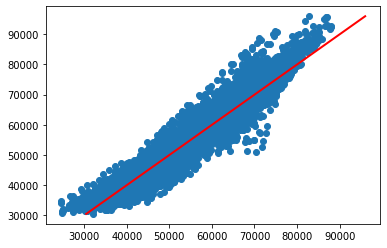

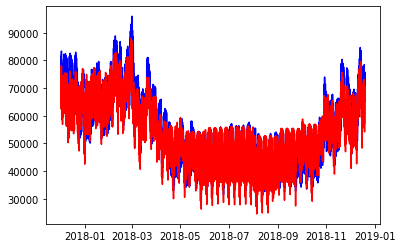

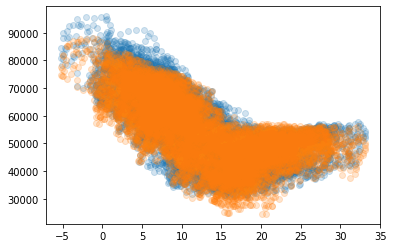

In [40]:
plt.scatter(forecast_test, y_test[['y']])
plt.plot([y_test[['y']].min(), y_test[['y']].max()], [y_test[['y']].min(), y_test[['y']].max()], 'r', lw=2)
plt.show()

plt.plot(y_test['ds'], y_test['y'], 'b', y_test['ds'], forecast_test, 'r')
plt.show()

plt.scatter(x_test['Th_prev'], y_test['y'], alpha=0.2)
plt.scatter(x_test['Th_prev'], forecast_test, alpha=0.2)
plt.show()

In [41]:
evaluation(y_train, y_test, forecast_train,  forecast_test)
eval_weekday, eval_hour, eval_JF = evaluation_par(x_test, y_test, forecast_test, avec_JF=True)

display(round(eval_weekday * 100, 1))
display(round(eval_hour * 100, 1))
display(round(eval_JF * 100, 1))

l'erreur relative moyenne de test est de :5.0%
l'erreur relative max de test est de :38.0%
le rmse de test est de :3583.0

l'erreur relative moyenne de train est de :5.0%
l'erreur relative max de train est de :52.4%
le rmse de test est de :3265.0


APE
        mean
weekday     
0        5.0
1        4.4
2        4.3
3        4.6
4        4.2
5        5.3
6        7.1

APE
     mean
hour     
0     5.4
1     5.8
2     6.0
3     6.2
4     6.6
5     6.4
6     5.1
7     5.5
8     6.6
9     5.8
10    4.9
11    4.4
12    4.2
13    3.8
14    4.1
15    4.3
16    4.4
17    4.4
18    4.5
19    4.8
20    4.1
21    4.1
22    4.3
23    4.5

APE
              mean
jours_feries      
0              4.8
1             11.6

#### Comment se distribue l'erreur ?

In [42]:
erreur_relative_test, erreur_moyenne_test, erreur_max_test, rmse = modelError(y_test, forecast_test)

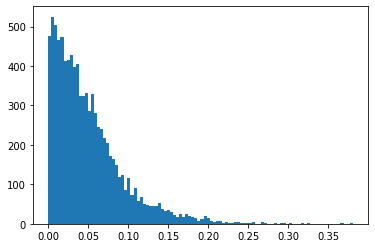

In [43]:
num_bins = 100
plt.hist(erreur_relative_test, num_bins)
plt.show()

#### A quel moment se trompe-t-on le plus ?

In [44]:
iplot([{"x": y_test['ds'], "y": erreur_relative_test}])

Regardons les erreurs les plus flagrantes :

In [45]:
q = 0.9975
threshold = np.quantile(erreur_relative_test.values, q)

print("Quantile des erreurs à {}% : {}".format(q * 100,  round(threshold, 5)))

Quantile des erreurs à 99.75% : 0.24592


In [46]:
error_order = np.argsort(erreur_relative_test.values)[::-1]
mask = (erreur_relative_test.iloc[error_order] >= threshold)
erreurs_df = pd.DataFrame(
    np.concatenate((y_test[['ds','y']],np.array([forecast_test]).T), axis=1),
    columns=["date","y","prev"]
)

display(erreurs_df.iloc[error_order][mask])

date      y     prev
753  2018-01-01 09:00:00+00:00  51035  70446.3
754  2018-01-01 10:00:00+00:00  52495  71778.1
752  2018-01-01 08:00:00+00:00  51462  68145.3
755  2018-01-01 11:00:00+00:00  54658  72109.3
6176 2018-08-15 08:00:00+00:00  34450  44862.4
5932 2018-08-05 04:00:00+00:00  34873  24557.4
3848 2018-05-10 08:00:00+00:00  37729  48767.6
6177 2018-08-15 09:00:00+00:00  36950  47759.2
3847 2018-05-10 07:00:00+00:00  35657  45779.9
5933 2018-08-05 05:00:00+00:00  34187  24511.2
756  2018-01-01 12:00:00+00:00  57169  72703.3
6178 2018-08-15 10:00:00+00:00  39298  49899.3
585  2017-12-25 09:00:00+00:00  55134  69983.3
759  2018-01-01 15:00:00+00:00  55044  69849.7
5931 2018-08-05 03:00:00+00:00  36373  26686.5
7324 2018-10-02 04:00:00+00:00  39535  49684.1
3632 2018-05-01 08:00:00+00:00  43639  54834.9
3631 2018-05-01 07:00:00+00:00  42033  52792.8
760  2018-01-01 16:00:00+00:00  54649  68607.4
751  2018-01-01 07:00:00+00:00  51180  64166.4
3800 2018-05-08 08:00:00+00:00  36946  46270.4
5908 2018-08-04 04:00:00+00:00  36481  27295.4
3849 2018-05-10 09:00:00+00:00  40310  50294.5
584  2017-12-25 08:00:00+00:00  54321  67682.4

In [47]:
y_test_copy = y_test[['ds','y']].copy()
y_test_copy["erreur_relative_%"] = erreur_relative_test.values * 100
y_test_copy['weekday'] = y_test_copy.ds.dt.weekday
y_test_copy['hour'] = y_test_copy.ds.dt.hour
y_test_copy['is_bank_holiday'] = x_test["jours_feries"]

groupe_wd = y_test_copy.groupby(['weekday'], as_index=True)
stats_wd = groupe_wd["y", "erreur_relative_%"].aggregate(["mean"])

groupe_hour = y_test_copy.groupby(['hour'], as_index=True)
stats_hour = groupe_hour["y", "erreur_relative_%"].aggregate(["mean"])

groupe_bh = y_test_copy.groupby(['is_bank_holiday'], as_index=True)
stats_bh = groupe_bh["y", "erreur_relative_%"].aggregate(["mean"])

display(stats_wd)
display(stats_hour)
display(stats_bh)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



y erreur_relative_%
                 mean              mean
weekday                                
0        55912.076515          4.971010
1        57483.568182          4.443767
2        57836.390909          4.344290
3        57280.214506          4.644500
4        56973.284091          4.216301
5        51864.092424          5.324835
6        49412.735606          7.123598

y erreur_relative_%
              mean              mean
hour                                
0     56202.244792          5.409071
1     51416.981771          5.816003
2     50179.838542          5.986725
3     47925.721354          6.232031
4     46197.690104          6.627684
5     46190.002604          6.376393
6     48590.125000          5.104833
7     52820.690104          5.492437
8     56147.507812          6.639368
9     58116.096354          5.818462
10    59410.278646          4.892748
11    59903.557292          4.443744
12    60717.179688          4.216109
13    61027.164062          3.785034
14    58974.330729          4.134367
15    57323.205729          4.250739
16    56078.023438          4.391567
17    55471.937500          4.413861
18    57007.054688          4.526182
19    59578.755208          4.752209
20    58856.611979          4.142392
21    56121.234375          4.063062
22    54331.255208          4.261005
23    57328.119792          4.480977

y erreur_relative_%
                         mean              mean
is_bank_holiday                                
0                55461.742181          4.815894
1                47947.261364         11.616696

Au vu des résultats précédents :
<font color= 'green'>

- que pensez-vous du modèle?
- comment se distribue l'erreur?
- quand se trompe-t-on le plus?
- quelles variables explicatives ajouter?

Vous pouvez aussi réessayer avec un cols_LR qui contient les mois et les heures.

</font>

## Modèles avancés (boîtes noires)

### Modèle RandomForest

<img src="pictures/randomForestExplain.png" width=500>

#### Choix des données d'entrée

In [48]:
cols_RF = ['lag1D','lag1W']\
+ cols_to_keep_weather\
+ cols_to_keep_month\
+ cols_to_keep_weekday\
+ cols_to_keep_hour\
+ cols_to_keep_holidays

list(cols_RF)

['lag1D',
 'lag1W',
 'Th_prev',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'JF_11Novembre',
 'JF_1erMai',
 'JF_8Mai',
 'JF_Ascension',
 'JF_Assomption',
 'JF_FeteNationale',
 'JF_Noel',
 'JF_NouvelAn',
 'JF_Paques',
 'JF_Pentecote',
 'JF_Toussaint']

In [49]:
display(x_train[cols_RF].head(20))

lag1D    lag1W   Th_prev  month_1  month_2  month_3  month_4  month_5  \
169  61958.0  57298.0  4.488565        1        0        0        0        0   
170  60990.0  56216.0  4.569400        1        0        0        0        0   
171  58975.0  53719.0  4.618140        1        0        0        0        0   
172  57192.0  51798.0  4.679810        1        0        0        0        0   
173  57510.0  52083.0  4.545550        1        0        0        0        0   
174  61825.0  56082.0  4.715685        1        0        0        0        0   
175  69625.0  63083.0  5.036705        1        0        0        0        0   
176  75459.0  68358.0  5.409585        1        0        0        0        0   
177  75389.0  69269.0  5.973030        1        0        0        0        0   
178  75146.0  68732.0  6.620940        1        0        0        0        0   
179  74677.0  68118.0  7.333400        1        0        0        0        0   
180  74580.0  68068.0  7.991080        1        0        0        0        0   
181  73477.0  67385.0  8.473500        1        0        0        0        0   
182  71690.0  65680.0  8.734080        1        0        0        0        0   
183  69921.0  63820.0  8.738110        1        0        0        0        0   
184  68678.0  62455.0  8.446135        1        0        0        0        0   
185  68956.0  63239.0  8.057810        1        0        0        0        0   
186  74375.0  68474.0  7.655990        1        0        0        0        0   
187  78424.0  71305.0  7.412200        1        0        0        0        0   
188  76005.0  68602.0  7.292275        1        0        0        0        0   

     month_6  month_7  ...  JF_1erMai  JF_8Mai  JF_Ascension  JF_Assomption  \
169        0        0  ...          0        0             0              0   
170        0        0  ...          0        0             0              0   
171        0        0  ...          0        0             0              0   
172        0        0  ...          0        0             0              0   
173        0        0  ...          0        0             0              0   
174        0        0  ...          0        0             0              0   
175        0        0  ...          0        0             0              0   
176        0        0  ...          0        0             0              0   
177        0        0  ...          0        0             0              0   
178        0        0  ...          0        0             0              0   
179        0        0  ...          0        0             0              0   
180        0        0  ...          0        0             0              0   
181        0        0  ...          0        0             0              0   
182        0        0  ...          0        0             0              0   
183        0        0  ...          0        0             0              0   
184        0        0  ...          0        0             0              0   
185        0        0  ...          0        0             0              0   
186        0        0  ...          0        0             0              0   
187        0        0  ...          0        0             0              0   
188        0        0  ...          0        0             0              0   

     JF_FeteNationale  JF_Noel  JF_NouvelAn  JF_Paques  JF_Pentecote  \
169                 0        0            0          0             0   
170                 0        0            0          0             0   
171                 0        0            0          0             0   
172                 0        0            0          0             0   
173                 0        0            0          0             0   
174                 0        0            0          0             0   
175                 0        0            0          0             0   
176                 0        0            0          0             0   
177               

#### Entrainement du modèle

In [50]:
# La cellule peut prendre un peu de temps à exécuter
rf_regr = RandomForestRegressor(
    n_estimators=30, 
    max_depth=20,
    n_jobs=3,
)

rf_regr.fit(x_train[cols_RF], y_train['y'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=3, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

<font color='green'>

* Grâce à l'aide de la fonction, expliquer les paramètres de cette méthode

</font>

#### Prediction

In [51]:
forecast_train = rf_regr.predict(x_train[cols_RF])
forecast_test = rf_regr.predict(x_test[cols_RF])

#### Evaluation

l'erreur relative moyenne de test est de :2.6%
l'erreur relative max de test est de :34.9%
le rmse de test est de :2271.0

l'erreur relative moyenne de train est de :1.0%
l'erreur relative max de train est de :15.5%
le rmse de test est de :798.0


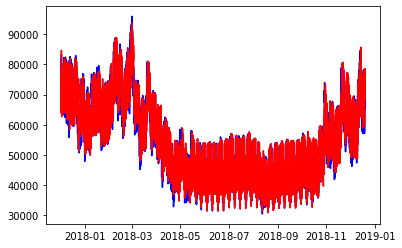

In [52]:
evaluation(y_train, y_test, forecast_train, forecast_test)

# on visualise nos previsions par rapport a la realité
plt.plot(y_test['ds'], y_test['y'], 'b', y_test['ds'], forecast_test, 'r')
plt.show()

In [53]:
eval_weakday, eval_hour, eval_JF = evaluation_par(x_test, y_test, forecast_test)

display(round(eval_weakday * 100, 1))
display(round(eval_hour * 100, 1))
display(round(eval_JF * 100, 1))

APE
        mean
weekday     
0        4.5
1        2.6
2        2.1
3        2.1
4        2.0
5        2.3
6        2.6

APE
     mean
hour     
0     2.3
1     2.4
2     2.4
3     2.6
4     2.8
5     2.9
6     3.1
7     3.4
8     3.2
9     2.9
10    2.5
11    2.3
12    2.4
13    2.5
14    2.4
15    2.5
16    2.7
17    2.7
18    2.7
19    2.5
20    2.6
21    2.4
22    2.4
23    2.1

APE
             mean
jours_feries     
0             2.5
1             7.3

In [54]:
erreur_relative_test, erreur_moyenne_test, erreur_max_test, rmse = modelError(y_test, forecast_test)

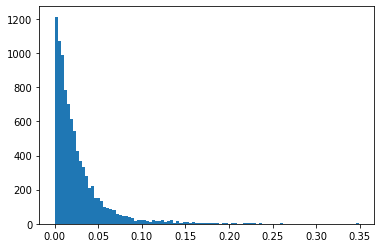

In [55]:
num_bins = 100
plt.hist(erreur_relative_test, num_bins)
plt.show()

#### A quel moment se trompe-t-on le plus ?

In [56]:
iplot([{"x": y_test['ds'], "y": erreur_relative_test}])

# Bonus: à vous de jouer

Bravo ! Vous avez déjà créé un premier modèle performant pour faire des prévisions sur une fenêtre glissante à horizon 24h !

Maintenant à vous de mettre votre expertise pour améliorer les performances de vos modèles. Vous pouvez continuer à explorer le problème selon plusieurs axes:
- choix du modèle (xgboost ?), tuning
- apprendre votre modèle sur une période différente
- créer de nouvelles variables explicatives ? Quid de la météo et de la température? Des jours fériés ? Du feature engineering plus complexe...
- détecter des outliers dans les données

Si vous voulez en apprendre plus => direction la formation DATAS2 !

Mettez-vous en 3 groupes, explorez pendant 30 minutes, et restituez.